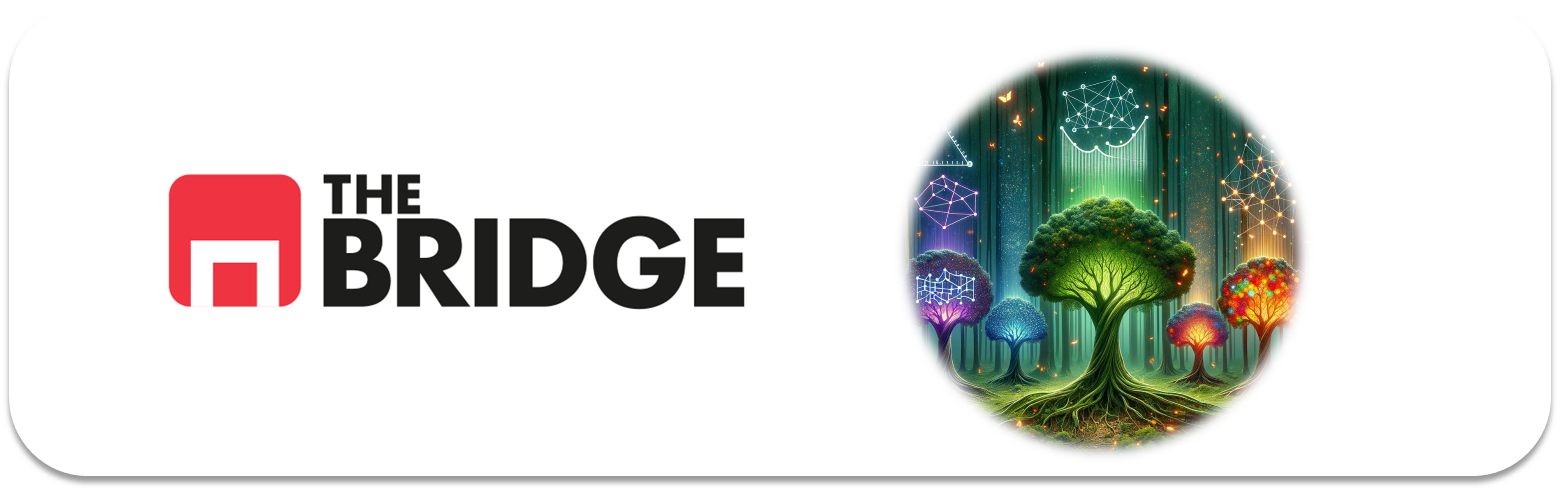

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de Hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

### **1. Problema**
#### **PROBLEMA DE NEGOCIO (Business Problem)**
La dirección del banco quiere saber:

**¿Qué clientes tienen más probabilidad de contratar un depósito a plazo?**

¿Por qué es importante?

- Para optimizar las campañas de marketing telefónico.
- Para reducir costes evitando llamar a clientes con baja probabilidad de contratar.
- Para aumentar la tasa de conversión enfocándose en los clientes más propensos.
- Para priorizar recursos (tiempo de agentes, presupuesto, etc.).

En resumen:

- El banco quiere mejorar la eficiencia y efectividad de sus campañas de marketing directo.

#### **PROBLEMA TÉCNICO (Machine Learning Problem)**
Traducimos el problema de negocio a un problema técnico:

**Construir un modelo supervisado de clasificación binaria que prediga si un cliente contratará (‘yes’) o no (‘no’) un depósito a plazo.**

Características técnicas:

- Tipo de aprendizaje: supervisado
- Tipo de salida (target): variable categórica binaria (y = yes/no)

Modelos a usar:

- Árbol de decisión (modelo principal)
- Regresión logística (baseline)

Métrica relevante:

- ROC-AUC
- Recall de la clase positiva
- F1
- Accuracy (menos útil por desbalanceo)

Además, el enunciado exige:

- Preprocesamiento (OneHot para categóricas)
- Train/test split
- Mini EDA
- Entrenamiento inicial
- Optimización de hiperparámetros del árbol
- Comparación con regresión logística
- Evaluación final sobre test
- Conclusión

En resumen:

**El problema técnico es entrenar y optimizar un clasificador que estime la probabilidad de suscripción a un depósito.**

### **2. Importamos el Dataset**

In [3]:
df_bank = pd.read_csv(
    "./data/bank-full.csv",
    sep=";",
    skip_blank_lines=True,
    on_bad_lines="skip",
    encoding="utf-8"
)
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


No hay nulos

### **3. Identificacion del Target y de analisis de su distribucion**

- El target es la y, porque es la pregunta a la que contesta el cliente con yes o no para la contratacion del deposito. 

-convierto el target en binario 

In [5]:
print("\nDistribución del target:")
print(df_bank["y"].value_counts(normalize=True))

df_bank["y"] = (df_bank["y"] == "yes").astype(int)



Distribución del target:
y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64


- Conclusión: el problema está desbalanceado. No podemos fiarnos solo de la accuracy; usaremos también roc_auc, recall y f1 para la clase positiva (“yes”)

### **4. Train/Split**

In [6]:
from sklearn.model_selection import train_test_split

X = df_bank.drop(columns=["y"])
y = df_bank["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTamaño train:", X_train.shape)
print("Tamaño test:", X_test.shape)



Tamaño train: (36168, 16)
Tamaño test: (9043, 16)


- stratify=y mantiene la proporción yes/no en train y test.
- A partir de aquí, todo el análisis y tuning se hace sobre train.

Si y se queda dentro de X:

- El modelo vería la respuesta correcta durante el entrenamiento.
- Aprendería a “copiar” el target.
- Obtendrías un modelo con accuracy del 100% en train.
- Pero fallaría completamente en test.
- Eso se llama data leakage (fuga de información), y es uno de los errores más graves en ML.

### **5. Mini-EDA**

In [7]:
X_train.describe()  # numéricas


,age,balance,day,duration,campaign,pdays,previous
count,36168.000000,36168.00000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000
mean,40.892999,1365.49342,15.817961,258.506940,2.763935,40.157238,0.581730
std,10.627075,3068.54350,8.331980,259.142445,3.104161,100.162614,2.408766
min,18.000000,-8019.00000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,74.00000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,451.00000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1430.25000,21.000000,318.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.00000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [8]:
X_train.select_dtypes("object").nunique()  # cardinalidad de categóricas

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
dtype: int64

### **6. Procesamiento de categoricas y numericas**

Los árboles no necesitan escalado, pero sí convertir categóricas a numéricas. Usamos OneHotEncoder dentro de un ColumnTransformer.

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

cat_cols = X_train.select_dtypes(include="object").columns
num_cols = X_train.select_dtypes(exclude="object").columns

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)


### **7. Baseline: Regresion logistica(sin optimizar)**

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.64      0.35      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043

ROC AUC (Logistic): 0.8998088334341446


c:\Users\César\OneDrive\Escritorio\DS\DS_ONLINE_CESAR\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\César\OneDrive\Escritorio\DS\DS_ONLINE_CESAR\venv\Lib\site-packages\sklearn\utils\_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


<Figure size 800x600 with 0 Axes>

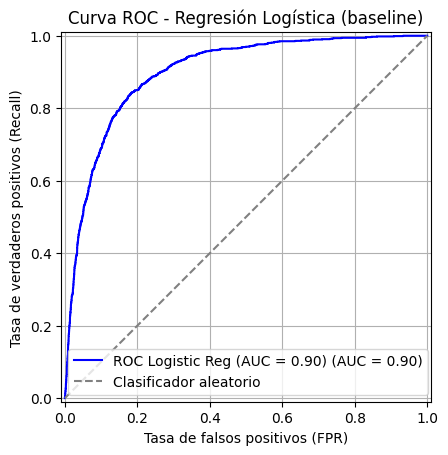

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score 
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

log_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

log_clf.fit(X_train, y_train)

y_pred_log = log_clf.predict(X_test)
y_proba_log = log_clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_log))
print("ROC AUC (Logistic):", roc_auc_score(y_test, y_proba_log))


# Curva ROC
plt.figure(figsize=(8, 6))

RocCurveDisplay.from_predictions(
    y_test,
    y_proba_log,
    name=f"ROC Logistic Reg (AUC = {roc_auc_score(y_test, y_proba_log):.2f})",
    color="blue"
)

# Línea diagonal del clasificador aleatorio
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Clasificador aleatorio")

plt.title("Curva ROC - Regresión Logística (baseline)")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (Recall)")
plt.grid(True)
plt.legend()
plt.show()



Qué estamos haciendo aquí:

- Entrenamos un modelo de clasificación lineal que predice la probabilidad de “yes”.
- Es nuestro modelo baseline: simple, robusto y buen punto de comparación.

### **8. Primer arbol de decision (sin ajustar hiperparametros)**

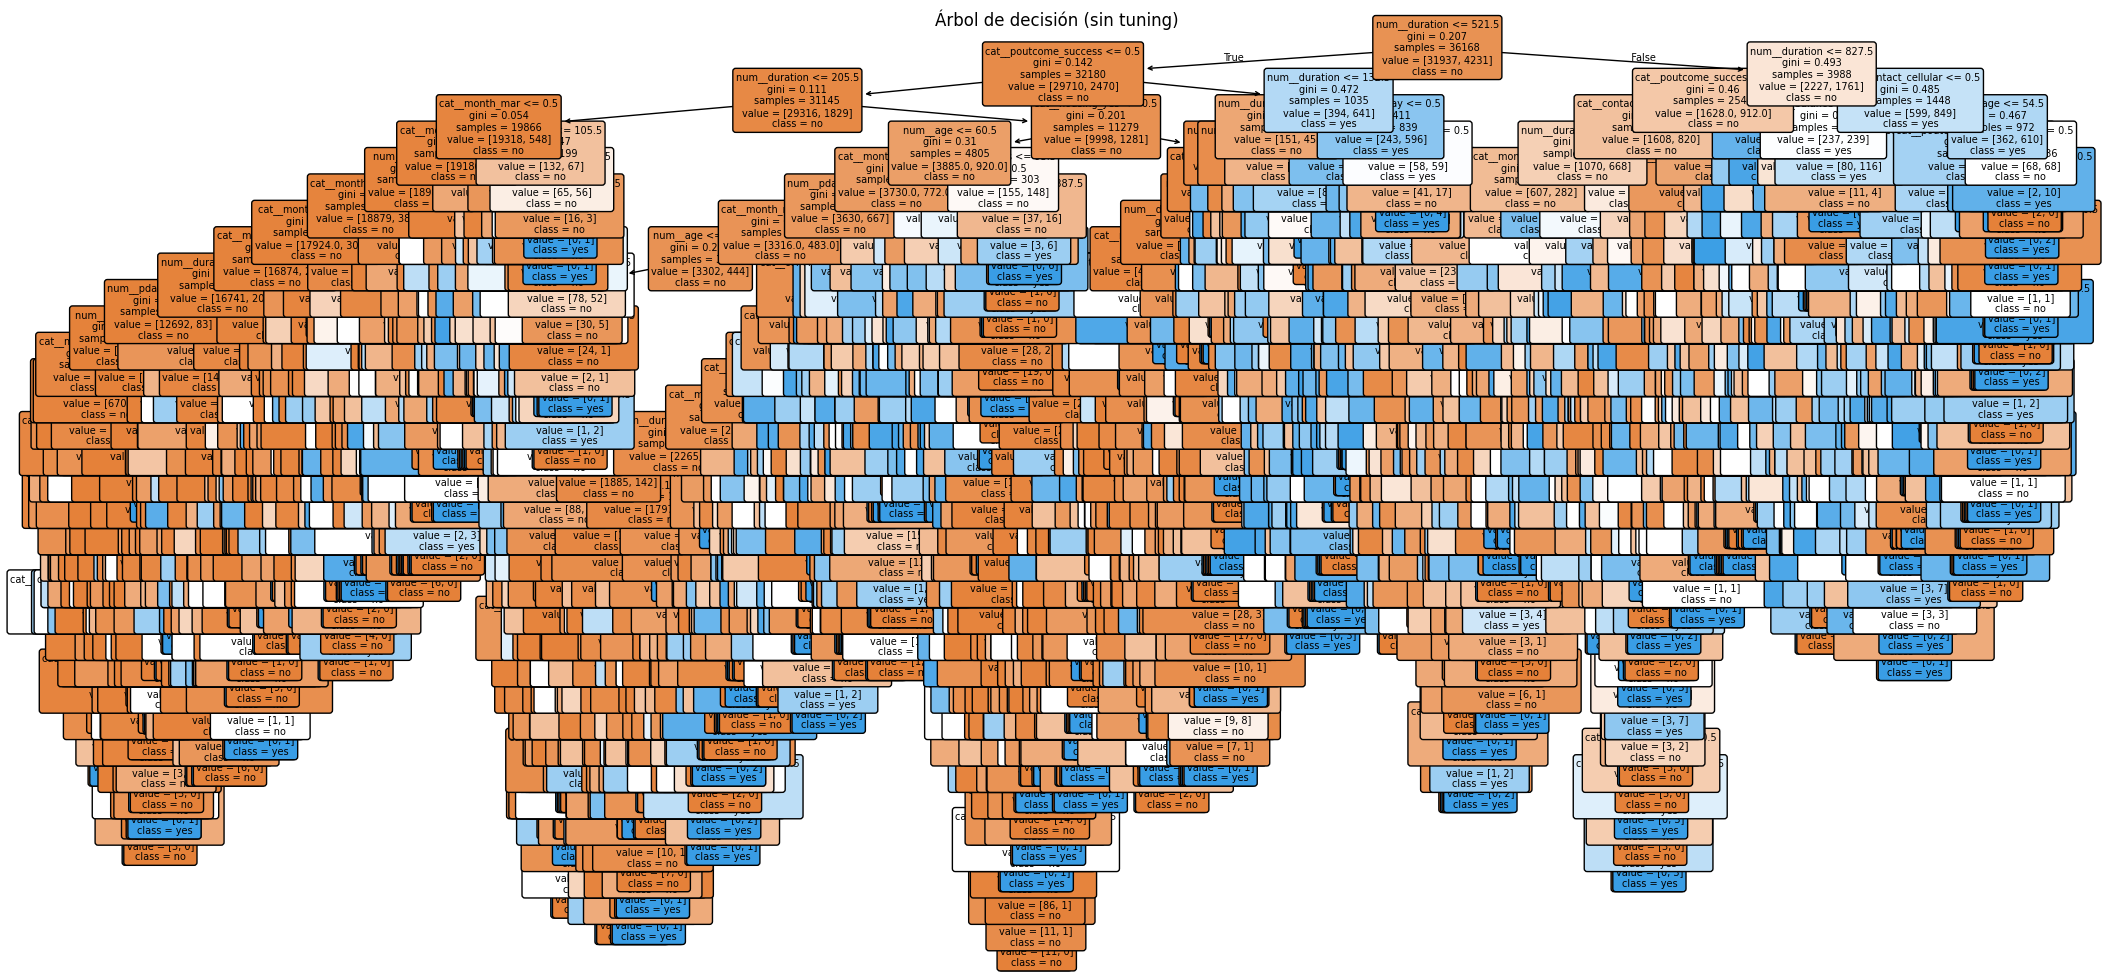

In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 1. Extraer el modelo del pipeline
modelo_arbol = tree_clf.named_steps["model"]

# 2. Obtener nombres de columnas transformadas
# Ajustamos el preprocesador para que genere los nombres
preprocess.fit(X_train)
feature_names = preprocess.get_feature_names_out()

# 3. Visualizar el árbol
plt.figure(figsize=(25, 12))
plot_tree(
    modelo_arbol,
    feature_names=feature_names,
    class_names=["no", "yes"],
    filled=True,
    rounded=True,
    fontsize=7
)
plt.title("Árbol de decisión (sin tuning)")
plt.show()


              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7985
           1       0.46      0.47      0.47      1058

    accuracy                           0.87      9043
   macro avg       0.70      0.70      0.70      9043
weighted avg       0.87      0.87      0.87      9043

ROC AUC (Tree sin tuning): 0.6989063852000384


c:\Users\César\OneDrive\Escritorio\DS\DS_ONLINE_CESAR\venv\Lib\site-packages\sklearn\utils\_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


<Figure size 800x600 with 0 Axes>

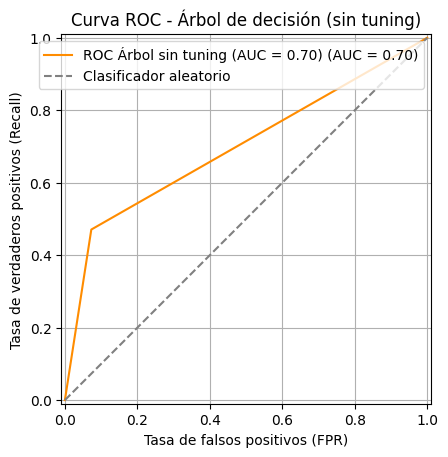

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

tree_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(random_state=42))
])

tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)
y_proba_tree = tree_clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_tree))
print("ROC AUC (Tree sin tuning):", roc_auc_score(y_test, y_proba_tree))

# Curva ROC 
plt.figure(figsize=(8, 6))

RocCurveDisplay.from_predictions(
    y_test,
    y_proba_tree,
    name=f"ROC Árbol sin tuning (AUC = {roc_auc_score(y_test, y_proba_tree):.2f})",
    color="darkorange"
)

# Línea diagonal del clasificador aleatorio
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Clasificador aleatorio")

plt.title("Curva ROC - Árbol de decisión (sin tuning)")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (Recall)")
plt.grid(True)
plt.legend()
plt.show()


Idea:
- Vemos cómo se comporta un árbol “a lo bruto”.
- Suele tender a sobreajustar si no se controla la profundidad y el tamaño de las hojas.

### **9. Optimizacion de hiperparametros del arbol**

Definimos un grid razonado:

- max_depth: controla la profundidad → complejidad del árbol.
- min_samples_split: mínimo de muestras para dividir un nodo.
- min_samples_leaf: mínimo de muestras en una hoja.
- criterion: gini vs entropy.

Mejores hiperparámetros: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 20, 'model__min_samples_split': 100}
Mejor score CV (ROC AUC): 0.9036708448208348


c:\Users\César\OneDrive\Escritorio\DS\DS_ONLINE_CESAR\venv\Lib\site-packages\sklearn\utils\_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


<Figure size 800x600 with 0 Axes>

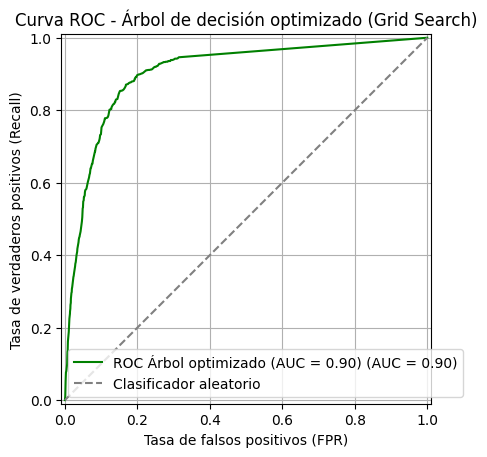

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "model__max_depth": [3, 5, 7, 9, None],
    "model__min_samples_split": [2, 10, 50, 100],
    "model__min_samples_leaf": [1, 5, 10, 20],
    "model__criterion": ["gini", "entropy"]
}

tree_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(random_state=42))
])

grid_search = GridSearchCV(
    estimator=tree_pipe,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor score CV (ROC AUC):", grid_search.best_score_)


# Curva ROC del mejor modelo 
best_tree = grid_search.best_estimator_
y_proba_best = best_tree.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 6))

RocCurveDisplay.from_predictions(
    y_test,
    y_proba_best,
    name=f"ROC Árbol optimizado (AUC = {roc_auc_score(y_test, y_proba_best):.2f})",
    color="green"
)

# Línea diagonal del clasificador aleatorio
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Clasificador aleatorio")

plt.title("Curva ROC - Árbol de decisión optimizado (Grid Search)")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (Recall)")
plt.grid(True)
plt.legend()
plt.show()



¿Está controlado el árbol?
- Sí, totalmente, aunque no por max_depth.

El control viene de:
- min_samples_leaf = 20
- min_samples_split = 100

Estos dos parámetros frenan el crecimiento del árbol incluso si max_depth=None.

¿Por qué?

Porque:
- Un nodo no puede dividirse si no tiene al menos 100 muestras
- Una hoja no puede tener menos de 20 muestras

Esto evita:
- hojas diminutas
- splits ruidosos
- sobreajuste
- probabilidades extremas
- ROC escalonada con pocos puntos

En otras palabras:
- Aunque max_depth=None, el árbol NO puede crecer libremente.
- Está fuertemente regularizado por los tamaños mínimos.

El score CV es el AUC promedio obtenido durante la validación cruzada en el conjunto de entrenamiento, y sirve para elegir los mejores hiperparámetros sin mirar el test.

### **10. Evaluacion del arbol contra el test**

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      7985
           1       0.59      0.47      0.52      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.71      0.73      9043
weighted avg       0.89      0.90      0.89      9043

ROC AUC (Tree optimizado): 0.9046217920415525


c:\Users\César\OneDrive\Escritorio\DS\DS_ONLINE_CESAR\venv\Lib\site-packages\sklearn\utils\_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


<Figure size 800x600 with 0 Axes>

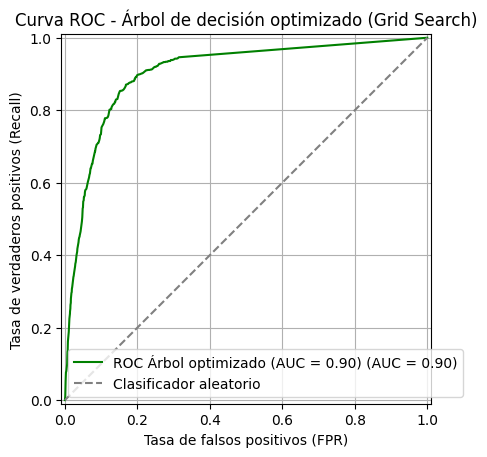

In [20]:
best_tree = grid_search.best_estimator_

y_pred_best = best_tree.predict(X_test)
y_proba_best = best_tree.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_best))
print("ROC AUC (Tree optimizado):", roc_auc_score(y_test, y_proba_best))

from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Curva ROC 
plt.figure(figsize=(8, 6))

RocCurveDisplay.from_predictions(
    y_test,
    y_proba_best,
    name=f"ROC Árbol optimizado (AUC = {roc_auc_score(y_test, y_proba_best):.2f})",
    color="green"
)

# Línea diagonal del clasificador aleatorio
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Clasificador aleatorio")

plt.title("Curva ROC - Árbol de decisión optimizado (Grid Search)")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (Recall)")
plt.grid(True)
plt.legend()
plt.show()



### **11. Conclusiones**


Contexto del problema
- El objetivo del proyecto es predecir si un cliente contratará un depósito a plazo (y = yes/no).
- Dado que la variable objetivo está fuertemente desbalanceada (muchos “no”, pocos “yes”), métricas como recall, f1 y roc_auc son más informativas que la accuracy.

Comparación de modelos

A continuación se comparan los tres modelos evaluados:

- Regresión logística (baseline, sin optimizar)
- Árbol de decisión sin tuning
- Árbol de decisión optimizado mediante Grid Search

#### **Baseline: Regresión logística (sin optimizar)**

Clase 1 (“yes”):
- Precision: 0.64
- Recall:    0.35
- F1-score:  0.45

- Accuracy: 0.90  
- ROC AUC:  0.8998

Interpretación: La regresión logística es un modelo lineal y estable. Presenta una alta precisión, pero un recall bajo, lo que significa que detecta pocos clientes que realmente contratarían el depósito. Aun así, su ROC AUC es muy alto, lo que indica buena capacidad de separación entre clases. Es un baseline sólido.

#### **Árbol de decisión sin ajustar hiperparámetros**

Clase 1 (“yes”):
- Precision: 0.46
- Recall:    0.47
- F1-score:  0.47

- Accuracy: 0.87  
- ROC AUC:  0.6989

Interpretación: El árbol sin tuning mejora el recall respecto a la regresión logística, pero empeora la precisión y obtiene un ROC AUC muy bajo, señal clara de sobreajuste. Su rendimiento global es inferior al baseline.

#### **Árbol de decisión optimizado (Grid Search)**
Mejores hiperparámetros encontrados:

- criterion = "entropy"
- max_depth = None
- min_samples_leaf = 20
- min_samples_split = 100

Resultados en test:

Clase 1 (“yes”):
- Precision: 0.59
- Recall:    0.47
- F1-score:  0.52

- Accuracy: 0.90  
- ROC AUC:  0.9046

Interpretación:  El árbol optimizado mejora claramente al árbol sin optimizar. Mantiene un recall razonable, aumenta la precisión, y obtiene el mejor F1 de los tres modelos. Además, su ROC AUC es el más alto, incluso ligeramente superior al de la regresión logística.

Comparación final
| Modelo                       | Precision (yes) | Recall (yes) | F1 (yes) | ROC AUC | Accuracy |
|------------------------------|-----------------|--------------|----------|---------|----------|
| Regresión logística          | 0.64            | 0.35         | 0.45     | 0.8998  | 0.90     |
| Árbol sin tuning             | 0.46            | 0.47         | 0.47     | 0.6989  | 0.87     |
| Árbol optimizado (GridSearch)| 0.59            | 0.47         | 0.52     | 0.9046  | 0.90     |


Conclusión general

La regresión logística es un baseline muy fuerte, con excelente ROC AUC y buena precisión, pero bajo recall.

El árbol sin tuning sobreajusta y rinde peor que la logística.

El árbol optimizado es el mejor modelo global:

- mejor F1 en la clase positiva,
- recall razonable,
- mejor ROC AUC de todos,
- misma accuracy que la logística.

Recomendación final:
- El árbol de decisión optimizado es el modelo más adecuado para este problema, ya que ofrece el mejor equilibrio entre recall, precisión y ROC AUC, superando tanto al árbol sin tuning como al baseline de regresión logística.